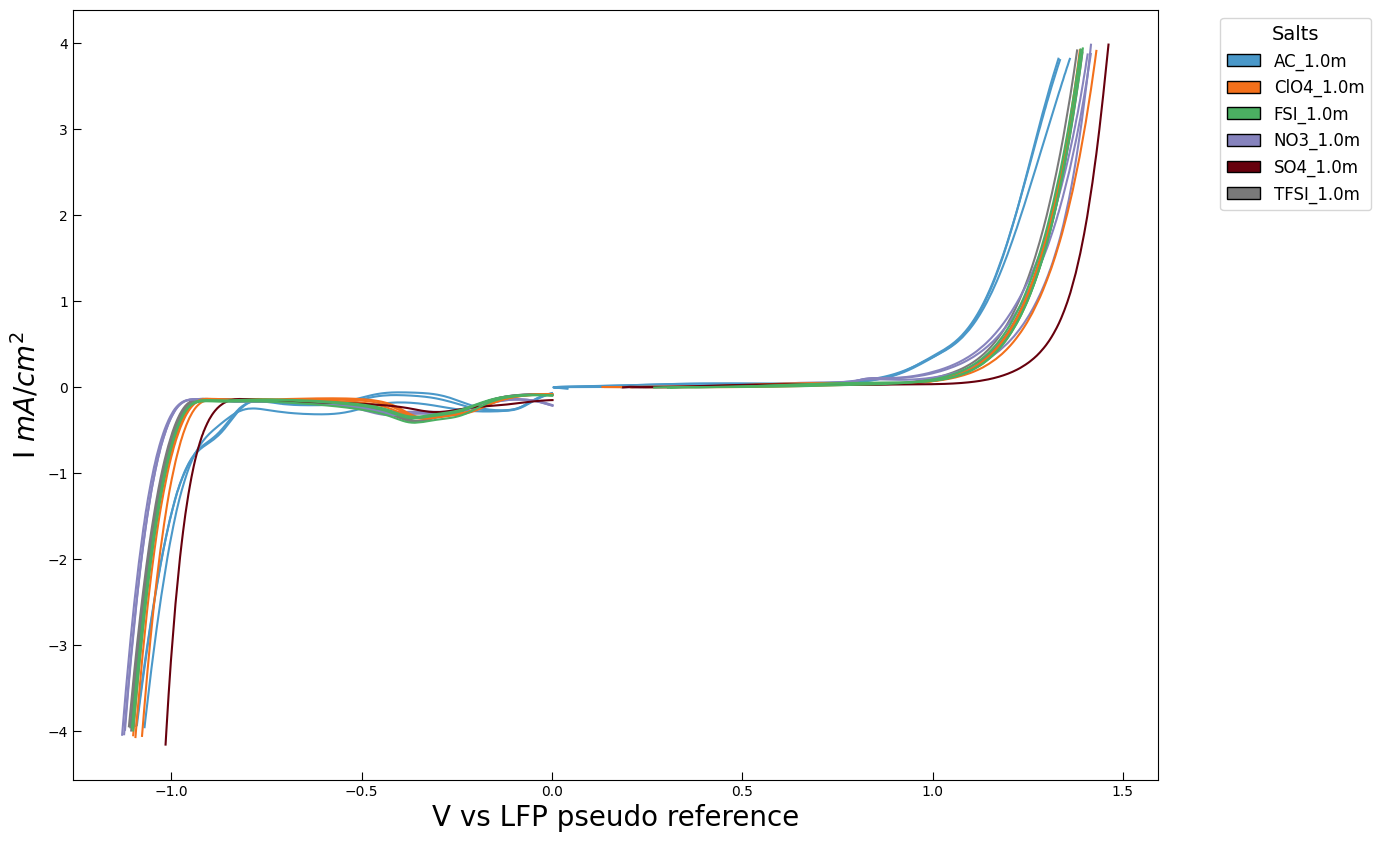

C:\Users\llf1362\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:284: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
C:\Users\llf1362\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:285: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


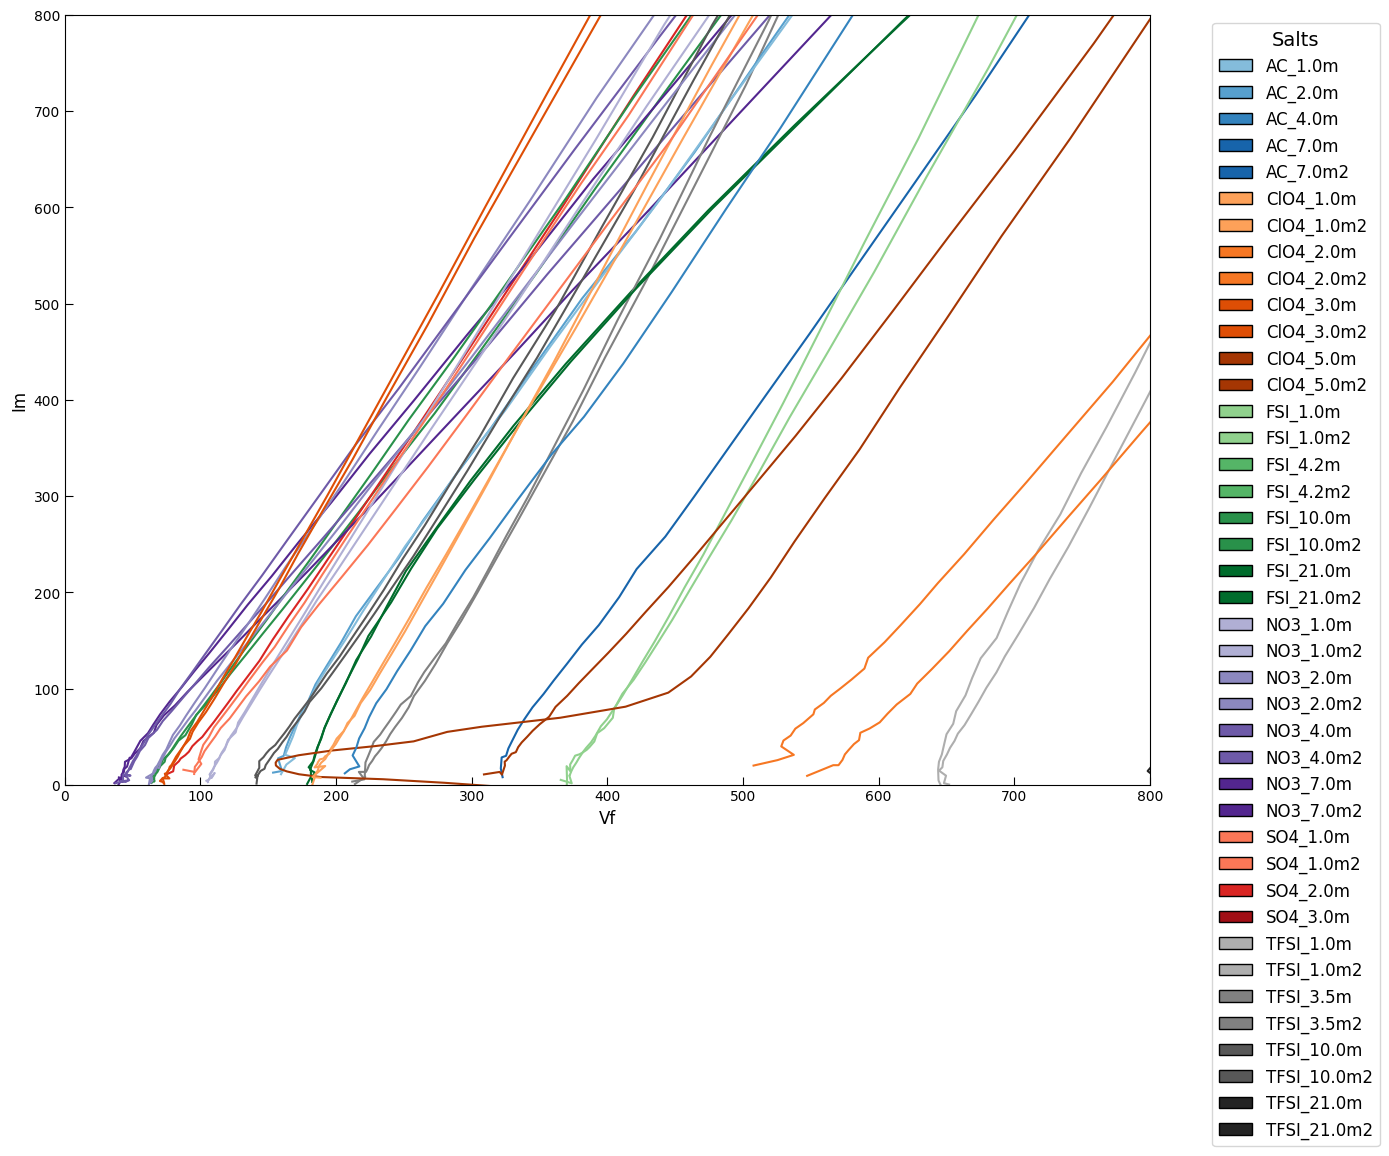

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib.cm as cm

from matplotlib.patches import Patch
from pathlib import Path

# enter folder containing CSVs to plot

# Group files by similar names (ignoring the last digit)
def get_grouped_files(files):
    grouped = {}
    for filename in files:
        # Assuming the last digit is at the end before the file extension
        base_name = filename.rsplit('_', 1)[0]
        if base_name not in grouped:
            grouped[base_name] = []
        grouped[base_name].append(filename)
    return grouped

def find_peaks_and_zero_crossings(data):
    # Find the index of the first occurrence of zero in 'Vf'
    zero_index = np.argmax(data['Vf'] >= 0)
    
    # Find the positive peak (maximum after the first zero crossing)
    positive_peak_index = np.argmax(data['Im'][zero_index:]) + zero_index
    
    # Find where the voltage crosses 0 after the positive peak
    # We are looking for the first zero-crossing point after the positive peak
    zero_cross_index = np.argmax(np.diff(np.sign(data['Vf'][positive_peak_index:])) != 0) + positive_peak_index
    
    # Find the negative peak (minimum after the 0V crossing)
    negative_peak_index = np.argmin(data['Im'][zero_cross_index:]) + zero_cross_index
    
    return positive_peak_index, zero_cross_index, negative_peak_index

def parse_files(file_list, type="cv"):
    """
    Currently only works for single salts! Assume three tests per salt.

    type is either cv or geis
    """
    salts_to_conc_list = {}
    salts = set()

    # tuple of salts and concentrations
    salt_and_conc = set()

    for file in file_list:
        stem = Path(file).stem
        stem_split = stem.split("_")

        # more than one salt
        if len(stem_split) != 3:
            continue

        salt, conc, test_type = stem_split

        # first part should be salt name
        salts.add(salt)

        # get conc
        conc = conc[:-1]
        dec_conc = float(conc.replace("p", "."))

        # keep track
        if salt in salts_to_conc_list:
            salts_to_conc_list[salt].append(dec_conc)
        else:
            salts_to_conc_list[salt] = [dec_conc]

        # from test_type, determine the test number for this test
        if type == "cv":
            suffix_length = 3
        else:
            suffix_length = 5

        test_num = test_type[:-suffix_length]

        if test_num == "":
            test_num = 1
        else:
            test_num = int(test_num)

        salt_and_conc.add((salt, conc, test_num))

    return salts, salt_and_conc, salts_to_conc_list

class CVPlotter():
    def __init__(self, folder_path):
        self.path = Path(folder_path)
        self.csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    def same_mat_diff_conc(self):
        cmap = cm.Blues
        plt.figure(figsize=(14, 10))
        for i, file in enumerate(self.csv_files):
            path = Path(file)
            df = pd.read_csv(path, index_col='# Point')
            positive_peak_index, zero_cross_index, negative_peak_index = find_peaks_and_zero_crossings(df)
            x = df["Vf"]
            y = df['Im']
            color = cmap(i / (len(self.csv_files) - 1))
            # Plot from 0 to positive peak
            plt.plot(x[:positive_peak_index+1],y[:positive_peak_index+1]*1000/0.020, color=color)
            
            # Plot from 0V crossing to negative peak
            plt.plot(x[zero_cross_index:negative_peak_index+1],y[zero_cross_index:negative_peak_index+1]*1000/0.020, color=color)

        plt.xlabel("Vf")
        plt.ylabel("Im")
        plt.show()
        
    def same_conc_diff_mat(self):
        plt.figure(figsize=(14, 10))
        for file in self.csv_files:
            path = Path(file)
            df = pd.read_csv(path, index_col='# Point')
            x = df["Vf"].to_numpy()
            y = df["Im"].to_numpy()

    def diff_mat_diff_conc(self):
        """
        Plot folder of data. 
        """
        sequential_cmaps = ['Greys', 'Purples', 'Blues', 'Oranges','Greens', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

        salts, salt_and_conc, salt_to_conc_list = parse_files(self.csv_files, type="cv")

        # assign each salt a colormap
        salt_to_cmap = {}

        i = 0
        for salt in salts:
            salt_to_cmap[salt] = plt.get_cmap(sequential_cmaps[i])
            i += 1

        plt.figure(figsize=(14, 10))
        legend_elements = []
        for tup in salt_and_conc:
            salt, conc, test_num = tup
            # rebuild file name
            if test_num == 1:
                prefix  = ""
            else:
                prefix = str(test_num)

            # we have three sets of data per run, one colour per run
            cmap = salt_to_cmap[salt]
            dec_conc = float(conc.replace("p", "."))
            conc_list = sorted(salt_to_conc_list[salt])
            ratio = (conc_list.index(dec_conc) + 1) / len(conc_list)

            cmap_intensity = 0.4 + ratio * 0.6
            plot_group_name = f"{salt}_{str(dec_conc)}m{prefix}"
            legend_elements.append(
                Patch(facecolor=cmap(cmap_intensity), edgecolor='black', label=plot_group_name)
            )

            # get corresponding cmap

            for i in range(3):

                file_name = f"{salt}_{conc}m_{prefix}cv{str(i)}.csv"
                path = self.path / Path(file_name)

                try:
                    df = pd.read_csv(path, index_col='# Point')
                except:
                    continue

                positive_peak_index, zero_cross_index, negative_peak_index = find_peaks_and_zero_crossings(df)
                x = df["Vf"]
                y = df['Im']

                # Plot from 0 to positive peak
                plt.plot(x[:positive_peak_index+1],
                        y[:positive_peak_index+1]*1000/0.020,
                        color = cmap(cmap_intensity),
                        )
                
                # Plot from 0V crossing to negative peak
                plt.plot(x[zero_cross_index:negative_peak_index+1],
                        y[zero_cross_index:negative_peak_index+1]*1000/0.020, 
                        color = cmap(cmap_intensity)
                        )

        # Custom sorting function
        def sort_key(s):
            s = s[0]
            # Split the string into prefix and numeric part
            prefix, num = s.split('_', 1)
            # Remove the 'm' and convert the numeric part to a float
            num = float(num.replace('m', ''))
            return (prefix, num)

        label_element_pairs = [(patch.get_label(), patch) for patch in legend_elements]
        label_element_pairs.sort(key=sort_key)  # Sort by label
        sorted_legend_elements = [patch for _, patch in label_element_pairs]

        # Add legend to the plot
        plt.legend(handles=sorted_legend_elements,  bbox_to_anchor=(1.05, 1), title="Salts", fontsize=12, title_fontsize=14, loc='upper left')
        plt.xlabel("V vs LFP pseudo reference", fontsize=20)
        plt.ylabel("I "  r"$mA/cm^2$", fontsize=20)
        plt.tick_params(axis='both', direction='in', length=6)
        plt.grid(False)
        plt.show()

    def set_path(self, new_path):
        # set new folder path to read CSVs
        self.path = Path(new_path)
        self.csv_files = [f for f in os.listdir(new_path) if f.endswith(".csv")]


class GEISPlotter():
    def __init__(self, folder_path):
        self.path = Path(folder_path)
        self.csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    def same_mat_diff_conc(self, showavg = False):
        # set showavg = True to show average zreals on legend
        for file in self.csv_files:
            path = Path(file)
            df = pd.read_csv(path, index_col='# point')
            x = df['zreal'].to_numpy()
            y = df['reflected_zimag'].to_numpy()

    def same_conc_diff_mat(self):
        for file in self.csv_files:
            path = Path(file)
            df = pd.read_csv(path, index_col='# point')
            x = df['zreal'].to_numpy()
            y = df['reflected_zimag'].to_numpy()

    def diff_mat_diff_conc(self):
        """
        Plot folder of data. 
        """

        sequential_cmaps = ['Greys', 'Purples', 'Blues', 'Oranges','Greens', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

        salts, salt_and_conc, salt_to_conc_list = parse_files(self.csv_files, type="geis")

        # assign each salt a colormap
        salt_to_cmap = {}

        i = 0
        for salt in salts:
            salt_to_cmap[salt] = plt.get_cmap(sequential_cmaps[i])
            i += 1


        plt.figure(figsize=(14, 10))
        legend_elements = []
        for tup in salt_and_conc:
            salt, conc, test_num = tup

            # rebuild file name
            if test_num == 1:
                prefix  = ""
            else:
                prefix = str(test_num)

            # we have three sets of data per run, one colour per run
            cmap = salt_to_cmap[salt]
            dec_conc = float(conc.replace("p", "."))
            conc_list = sorted(salt_to_conc_list[salt])
            ratio = (conc_list.index(dec_conc) + 1) / len(conc_list)

            cmap_intensity = 0.4 + ratio * 0.6
            plot_group_name = f"{salt}_{str(dec_conc)}m{prefix}"
            legend_elements.append(
                Patch(facecolor=cmap(cmap_intensity), edgecolor='black', label=plot_group_name)
            )

            # get corresponding cmap
            zreal_totals = pd.Series()
            zimag_totals = pd.Series()
            n = 0

            for i in range(3):

                file_name = f"{salt}_{conc}m_{prefix}geis{str(i)}.csv"
                path = self.path / Path(file_name)

                try:
                    df = pd.read_csv(path, index_col='# point')
                except:
                    continue

                if zreal_totals.empty:
                    zreal_totals = df["zreal"]
                    zimag_totals = df['reflected_zimag']
                else:
                    zreal_totals += df["zreal"]
                    zimag_totals += df['reflected_zimag']

                n += 1

            zreal_avg = zreal_totals / n
            zimag_avg = zimag_totals / n

            plt.plot(
                zreal_avg, zimag_avg, 
                label=None,  # No individual label for each file
                color=cmap(cmap_intensity)
            )

        # Custom sorting function
        def sort_key(s):
            # Split the string into prefix and numeric part
            s = s[0]
            prefix, num = s.split('_', 1)
            # Remove the 'm' and convert the numeric part to a float
            num = float(num.replace('m', ''))
            return (prefix, num)

        label_element_pairs = [(patch.get_label(), patch) for patch in legend_elements]
        label_element_pairs.sort(key=sort_key)  # Sort by label
        sorted_legend_elements = [patch for _, patch in label_element_pairs]

        # Add legend to the plot
        plt.ylim((0, 800))
        plt.xlim((0, 800))
        plt.legend(handles=sorted_legend_elements, bbox_to_anchor=(1.05, 1), title="Salts", fontsize=12, title_fontsize=14, loc='upper left')
        plt.xlabel("Vf", fontsize=12)
        plt.ylabel("Im", fontsize=12)
        plt.tick_params(axis='both', direction='in', length=6)
        plt.grid(False)
        plt.show()

    def set_path(self, new_path):
        # set new folder path to read CSVs
        self.path = Path(new_path)
        self.csv_files = [f for f in os.listdir(new_path) if f.endswith(".csv")]



cvplotter = CVPlotter(Path(r"C:\Users\llf1362\Desktop\SingleSaltData\1mSalt"))

cvplotter.diff_mat_diff_conc()
eisplotter = GEISPlotter(Path(r"C:\Users\llf1362\Desktop\SingleSaltData\eis"))
eisplotter.diff_mat_diff_conc()

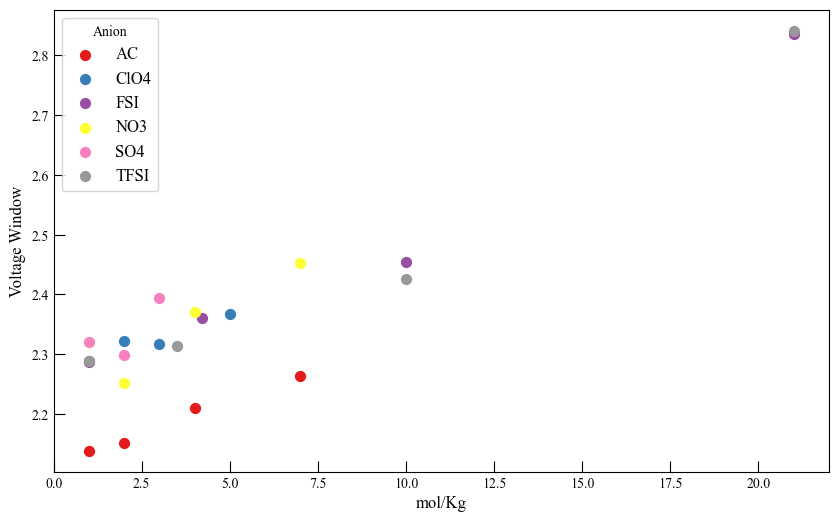

In [6]:
import os
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

def cv_interpret(filename):
        df_file = filename
        df = pd.read_csv(df_file, index_col='# Point')

        positive,zero,negative = find_peaks_and_zero_crossings(df)

        targ_max = 0.000024
        targ_min = -0.000024

        im_col = df["Im"]
        im_colPositive = im_col[0:positive]
        im_colNegative = im_col[zero:negative]

        vf_col = df["Vf"]
        vf_colPositive = vf_col[0:positive]
        vf_colNegative = vf_col[zero:negative]

        #get xmax
        #translate column by target and get absolute values. find index of minimum (closest to 0)
        im_col_translated_pos = (im_colPositive - targ_max).abs()
        min_idx_pos = im_col_translated_pos.idxmin()
        vf_max = vf_colPositive.loc[min_idx_pos]  # Use .loc to get the value at that index

        #get xmin
        im_col_translated_neg = (im_colNegative + targ_max).abs()
        min_idx_neg = im_col_translated_neg.idxmin()
        vf_min = vf_colNegative.loc[min_idx_neg]  # Use .loc to get the value at that index

        vf_diff = vf_max-vf_min

        return(vf_diff,vf_max,vf_min)

path = Path(r"c:\Users\llf1362\Desktop\SingleSaltData\cv")
folder_path = r"c:\Users\llf1362\Desktop\SingleSaltData\cv"

# Assuming csv_files and folder_path are already defined
# Initialize a dictionary to hold groups based on the compound name and the number before "m"
grouped_results = defaultdict(list)

# Define the regular expression pattern to extract the compound name and the number before 'm'
pattern = r"([^_]+)_(\d+(?:\.?\d*|p\d+)?)m"

# Initialize a list to collect data for plotting
plot_data = []
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
for i in csv_files:
    # Get the full file path
    full_file_path = os.path.join(folder_path, i)
    stem = Path(i).stem
    stem_split = stem.split("_")
    # more than one salt
    if len(stem_split) != 3:
        continue
    # Extract the compound name (everything before '_') and the number before 'm'
    match = re.search(pattern, i)
    if match:
        compound_name = match.group(1)  # Everything before the first '_'
        number = match.group(2)  # The number before 'm' (e.g., '1', '2', '21', '4p2')

        # Handle 'p' as a decimal point for mixed numbers (like '4p2' -> '4.2')
        if 'p' in number:
            number = number.replace('p', '.')

        # Call cv_interpret or whatever function you're using
        diff, maxV, minV = cv_interpret(full_file_path)
        
        # Group the results by compound name and number before 'm'
        grouped_results[(compound_name, number)].append(diff)
        

    
for key, diff_list in grouped_results.items():
    compound_name, number = key
    avg_diff = sum(diff_list) / len(diff_list)  # Calculate the average diff
    plot_data.append({
        'compound': compound_name,
        'number': float(number),  # Convert number to float for proper plotting
        'avg_diff': avg_diff
    })


# Convert the plot_data list into a pandas DataFrame
df = pd.DataFrame(plot_data)

# Set the font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Create the plot
plt.figure(figsize=(10, 6))

# Loop through the compounds and plot each one with a unique color
compounds = df['compound'].unique()
colors = plt.cm.get_cmap('Set1', len(compounds))  # Use a colormap with a distinct color for each compound

for idx, compound in enumerate(compounds):
    # Filter data for the current compound
    compound_data = df[df['compound'] == compound]
    
    # Plot the average diff for the current compound with smaller points
    plt.scatter(compound_data['number'], compound_data['avg_diff'], label=compound, color=colors(idx), s=50)  # s=50 for smaller points

# Add labels and a title
plt.xlabel("mol/Kg", fontsize=12)
plt.ylabel("Voltage Window", fontsize=12)
plt.legend(title="Anion", fontsize=12)  # Set font size for the legend

# Move tick marks inside
plt.tick_params(axis='both', direction='in', length=8, labelsize=10)

# Show the plot
plt.show()

In [3]:
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from pathlib import Path
import sys
import pandas as pd
from utils.PStat import dataanalysis
import matplotlib.pyplot as plt

def run_bumps(path):
    bumps = dataanalysis.DataAnalyzer(path)
    obj = bumps.run("lebronJames")
    print(obj)

    R1 = obj["R1"]
    if "(" in R1:
        open_paren = R1.index("(")
        close_paren = R1.index(")")
        R1 = R1[:open_paren] + R1[close_paren+1:]  
    R1 = float(R1)

    R2 = obj["R2"]
    if "(" in R2:
        open_paren = R2.index("(")
        close_paren = R2.index(")")
        R2 = R2[:open_paren] + R2[close_paren+1:]  
    R2 = float(R2)

    alpha1 = obj["alpha1"]
    if "(" in alpha1:
        open_paren = alpha1.index("(")
        close_paren = alpha1.index(")")
        alpha1 = alpha1[:open_paren] + alpha1[close_paren+1:]  
    alpha1 = float(alpha1)



    sigma1 = obj["sigma1"]
    if "(" in sigma1:
        open_paren = sigma1.index("(")
        close_paren = sigma1.index(")")
        sigma1 = sigma1[:open_paren] + sigma1[close_paren+1:]  
    sigma1 = float(sigma1)


 
    def impedance1( x, R1, R2, alpha1, sigma1):
        w = 2*np.pi*x
        RC2 = 1 /(1/R2 + sigma1*((1j*w)**alpha1))
        Rf = R1 + RC2
        return Rf
       
    path = Path(path)
    df = pd.read_csv(path, index_col='# point')
    x = df['zreal'].to_numpy()
    y = df['reflected_zimag'].to_numpy()

    x1 = np.logspace(1,6, num=50)



   #r = impedance(x, R1, R2, alpha1, alpha2,  sigma1, sigma2)
    r = impedance1(x1, R1,  R2, alpha1, float(sigma1))

    plt.plot(r.real,-r.imag)
    plt.plot(x,y)
    plt.ylim((0, 2000))
    plt.xlim((0, 2000))
    plt.show()
    return

run_bumps(r"c:\Users\llf1362\Desktop\SingleSaltData\eis\TFSI_1m_geis1.csv")

{'final chisq': '34.601(45)', 'R1': '669.3(68)', 'R2': '134.88529907087155379485921002924442291259765625000000000000000000000000000000000000000000000000000000000000000000000(10)e120', 'alpha1': '0.7933(22)', 'sigma1': '2.010(26)e-6'}
